In [1]:
%load_ext tensorboard

In [2]:
import sys
sys.path.append("..")

import numpy as np
import data_frame
import models
import importlib
import evaluator as ev
import matplotlib.pyplot as plt

In [3]:
filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())

In [8]:
# df.data.loc[df.data["faint"], "MAG_GAAP_r"].max()

/home/kdrabicki/anaconda3/envs/test_env/lib/python3.12/site-packages/tf_keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MixtureNormal.new(  # pylint: disable=g-long-lambda
            t, num_components, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 70.


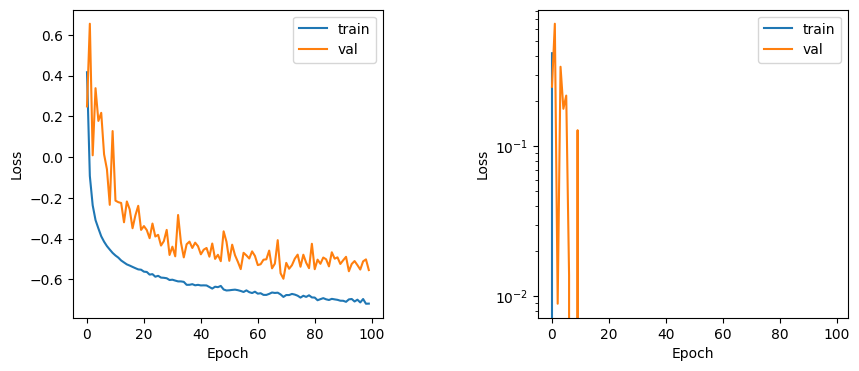

In [70]:
importlib.reload(models)

model = models.MLModelContext(strategy=models.ANNDoubleGauss(df))
model.train()
model.test_predict()

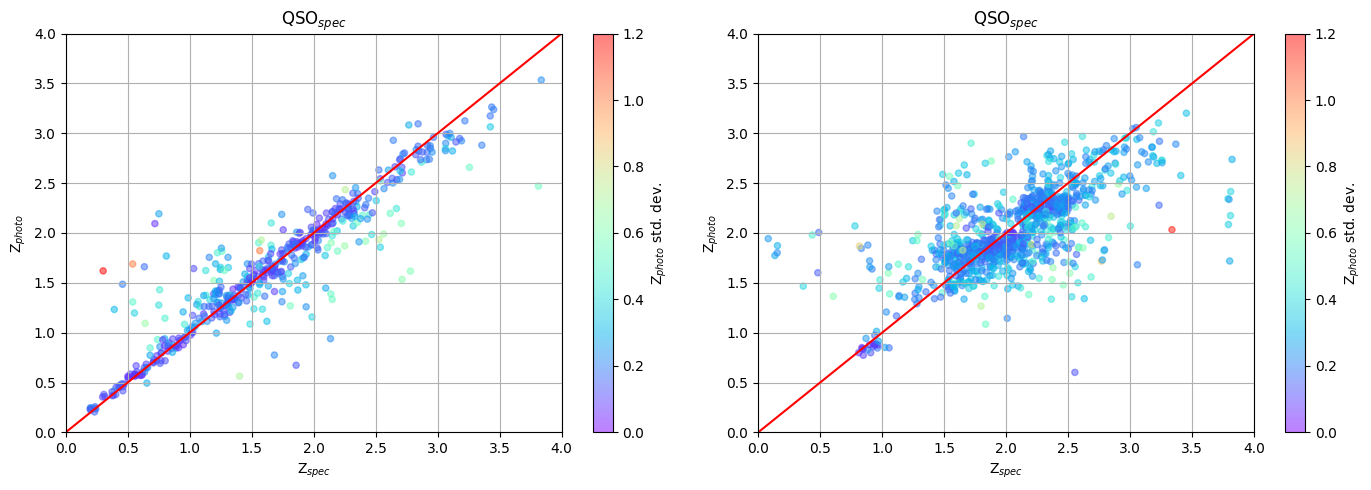

,MSE,R^2,Redshift error,NLL
test,0.091192,0.837284,"(0.005754936431570694, 0.12737518405005963)",-0.58374
faint,0.213801,0.373686,"(-0.0022131236020222853, 0.16315308547637353)",0.50225


In [71]:
importlib.reload(ev)

evaluator = ev.Evaluator(df)
evaluator.redshift_std()
metrics = evaluator.evaluate_metrics()
# metrics.to_csv("../../metrics/dg_mean_stddev_dropout_4.csv")
metrics

In [52]:
-df.data.loc[df.data["split"]=="test", "log_prob"].mean()

np.float32(-0.024407312)

In [24]:
df.data[df.data["split"] == "test"].to_csv("../../double_gaussian_output")

In [37]:
import tensorflow as tf
y_test = model.strategy.y_test
y_test = y_test[:10].values.reshape(-1,1)
y_model = raw_model(X_test[:10])
print(y_model.log_prob(y_test))
y_model = raw_model(X_test[:2])
y_model.log_prob(y_test[:2])

tf.Tensor(
[ 1.5704626   0.691951    1.0740134   0.70880467  0.49505782  0.05597358
  1.7241155   1.9196768  -0.32461882  0.47236603], shape=(10,), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5704626, 0.691951 ], dtype=float32)>

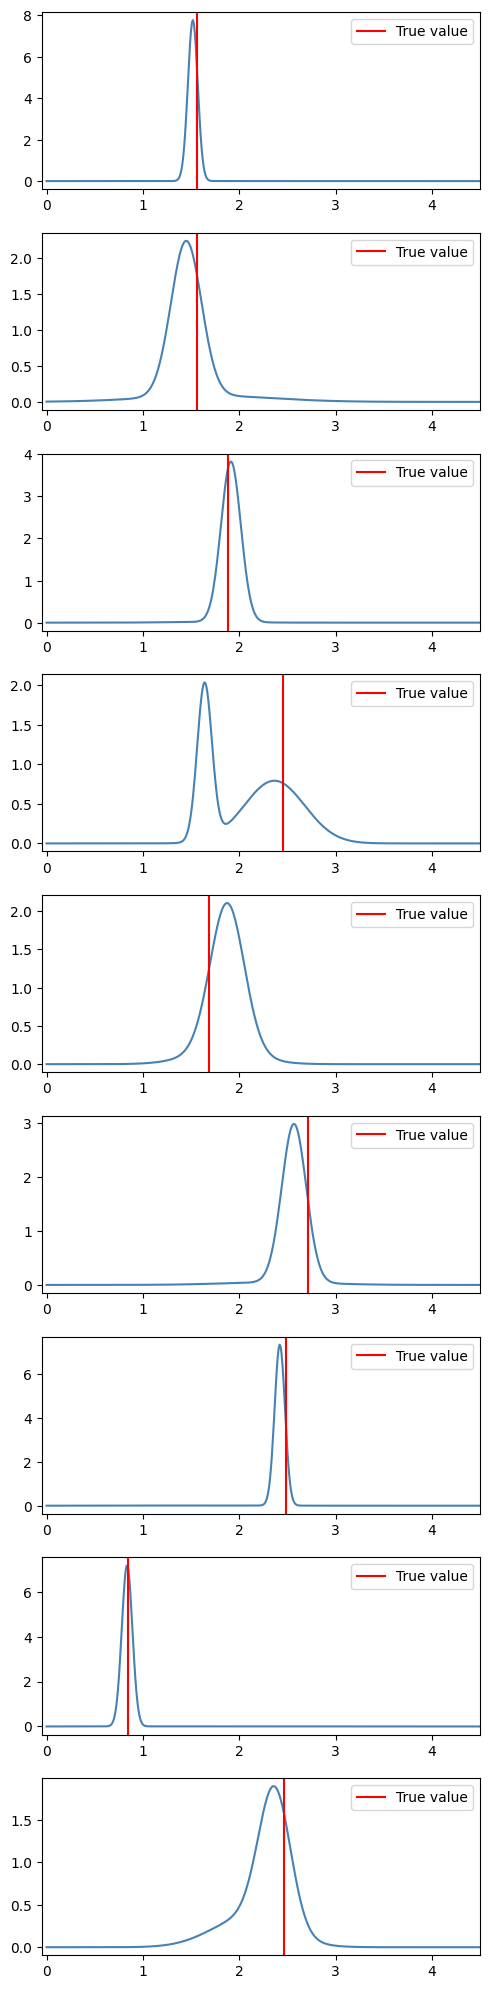

In [72]:
X_test = model.strategy.X_test
y_test = model.strategy.y_test
raw_model = model.strategy.network
scaler = model.strategy.scaler
X_test = scaler.transform(X_test)
points = np.arange(0,6,0.01)


fig, axes = plt.subplots(9, 1, figsize=(5, 20))

for ax, i in zip(axes, range(0,10)):
    x_input = X_test[i:i+1]
    y_model = raw_model(x_input)

    probs = []
    for point in points:
        log_prob = y_model.log_prob(point)
        probs.append(np.exp(log_prob))

    ax.plot(points, probs, color='steelblue')
    ax.axvline(y_test.values[i], color='red', linestyle='-', label='True value')
    ax.set_xlim(-0.05,4.5)
    ax.legend()


plt.tight_layout()
plt.show()
# # x=7357 Large redshift
# # x=3 Two modes
# x = 7357
# y_model = raw_model(X_test[x:x+1])
# y_sample = y_model.sample(1000000).numpy().reshape(-1)
# print(np.median(y_sample))
# print(y_test.values[x])
# print(y_model.mean())
# print(y_model.stddev())
# plt.hist(y_sample, bins=1000)
# # plt.xlim(1.2,1.8)
# plt.show()

# means = y_model.components_distribution.distribution.loc.numpy()
# stds = y_model.components_distribution.distribution.scale.numpy() 
# means, stds

In [2]:
%tensorboard --logdir ../../logs/fit